In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")

In [4]:
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from torchvision.models import resnet50
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from torch.utils.data import DataLoader
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor

In [5]:
def load_model_transform(modelname, device="cuda"):
    # Prepare model and transforms
    if modelname == "resnet50_robust":
        model = resnet50(pretrained=False)
        model.load_state_dict(th.load("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/checkpoints/imagenet_linf_8_pure.pt"))
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50":
        model = resnet50(pretrained=True)
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    elif modelname == "resnet50_clip":
        import clip
        model_clip, preprocess = clip.load('RN50', device=device)
        model = model_clip.visual
        transforms_pipeline = preprocess
    elif modelname == "resnet50_dino":
        # https://github.com/facebookresearch/dino
        model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')
        transforms_pipeline = T.Compose([
            T.ToTensor(),
            T.Resize((224, 224)),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    else:
        raise ValueError(f"Unknown model: {modelname}")
        # model = timm.create_model(modelname, pretrained=True).to(device).eval()
        # data_config = timm.data.resolve_model_data_config(model)
        # transforms_pipeline = timm.data.create_transform(**data_config, is_training=False)
    model = model.to(device).eval()
    model.requires_grad_(False)
    
    return model, transforms_pipeline

In [6]:
subject_id =  'paul_20241119-20241122' 
modelname = "resnet50_robust"
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
figdir = join(dataroot, "model_outputs", subject_id, )
os.makedirs(figdir, exist_ok=True)
fit_models_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth"))
Xtfmer_lyrswp_RidgeCV = th.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), "rb"))
result_df_lyrswp_RidgeCV = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
pred_data = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))

In [7]:
result_df_lyrswp_RidgeCV

,Unnamed: 0,Unnamed: 1,alpha,train_score,test_score,n_feat
0,.layer4.Bottleneck0_srp,RidgeCV,[1.e+04 1.e+04 1.e+06 1.e+04 1.e+05 1.e+04 1.e...,0.474555,0.144210,5944
1,.layer4.Bottleneck0_pca1000,RidgeCV,[1.e+04 1.e+04 1.e+05 1.e+04 1.e+05 1.e+04 1.e...,0.493349,0.163932,1000
2,.layer4.Bottleneck1_srp,RidgeCV,[1.e+04 1.e+04 1.e+05 1.e+04 1.e+05 1.e+04 1.e...,0.441853,0.148078,5944
3,.layer4.Bottleneck1_pca1000,RidgeCV,[1.e+04 1.e+04 1.e+05 1.e+04 1.e+05 1.e+04 1.e...,0.502595,0.160563,1000
4,.layer4.Bottleneck2_srp,RidgeCV,[1.e+05 1.e+05 1.e+06 1.e+05 1.e+05 1.e+04 1.e...,0.392761,0.151994,5944
5,.layer4.Bottleneck2_pca1000,RidgeCV,[1.e+04 1.e+05 1.e+06 1.e+05 1.e+05 1.e+04 1.e...,0.430186,0.157556,1000


In [6]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id =  'paul_20241119' 
# Load data
data_dict = load_neural_data(data_path, subject_id, stimroot)
image_fps = data_dict['image_fps']
resp_mat = data_dict['resp_mat']
reliability = data_dict['reliability']
ncsnr = data_dict['ncsnr']

In [7]:
chan_msk = ncsnr > 0.8
print(f"Using {chan_msk.sum()} out of {chan_msk.shape[0]} channels")
for k, v in pred_data["D2_per_unit_test_dict"].items():
    print(k, v[chan_msk].mean())

Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.24510798994714875
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.28037262488102976
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.24794823075047642
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.2801949067450697
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.2686220619945388
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.2682572684280461


In [27]:
key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl")

regressor = fit_models_lyrswp_RidgeCV[key]
Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
pred_rsp = pred_data["pred_dict"][key]
D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]

readout = LinearLayer_from_sklearn(regressor)
th.save(readout.state_dict(), readout_path)
pkl.dump(Xtfmer, open(Xtransform_path, "wb"))
th.save({
    "reliability": reliability,
    "ncsnr": ncsnr,
    "D2_per_unit_test": D2_per_unit_test,
    "D2_per_unit_train": D2_per_unit_train
}, meta_path)

In [35]:
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
stimroot = join(dataroot, "shared1000")
data_path = join(dataroot, "vvs-accentuate-day1_normalize_paul_241119.h5")
subject_id =  'paul_20241119' 
# Load data

for modelname in ["resnet50_robust", "resnet50", "resnet50_clip", "resnet50_dino"]:
    figdir = join(dataroot, "model_outputs", subject_id, )

    fit_models_lyrswp_RidgeCV = th.load(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth"))
    Xtfmer_lyrswp_RidgeCV = th.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl"), "rb"))
    result_df_lyrswp_RidgeCV = pd.read_csv(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv"))
    pred_data = pkl.load(open(join(figdir, f"{subject_id}_{modelname}_sweep_regressors_layers_pred_meta.pkl"), "rb"))
    data_dict = load_neural_data(data_path, subject_id, stimroot)

    image_fps = data_dict['image_fps']
    resp_mat = data_dict['resp_mat']
    reliability = data_dict['reliability']
    ncsnr = data_dict['ncsnr']

    print(f"Model: {modelname}")
    chan_msk = ncsnr > 0.8
    print(f"Using {chan_msk.sum()} out of {chan_msk.shape[0]} channels")
    for k, v in pred_data["D2_per_unit_test_dict"].items():
        print(k, v[chan_msk].mean())

    key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
    # export paths 
    readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
    Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
    meta_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl")

    regressor = fit_models_lyrswp_RidgeCV[key]
    Xtfmer = Xtfmer_lyrswp_RidgeCV[key[0]]
    pred_rsp = pred_data["pred_dict"][key]
    D2_per_unit_test = pred_data["D2_per_unit_test_dict"][key]
    D2_per_unit_train = pred_data["D2_per_unit_train_dict"][key]

    readout = LinearLayer_from_sklearn(regressor)
    th.save(readout.state_dict(), readout_path)
    pkl.dump(Xtfmer, open(Xtransform_path, "wb"))
    th.save({
        "reliability": reliability,
        "ncsnr": ncsnr,
        "D2_per_unit_test": D2_per_unit_test,
        "D2_per_unit_train": D2_per_unit_train
    }, meta_path)

Model: resnet50_robust
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.24510798994714875
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.28037262488102976
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.24794823075047642
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.2801949067450697
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.2686220619945388
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.2682572684280461
Model: resnet50
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.2636292499760762
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.2733498696896721
('.layer4.Bottleneck1_srp', 'RidgeCV') 0.2549499686043723
('.layer4.Bottleneck1_pca1000', 'RidgeCV') 0.26240913071028354
('.layer4.Bottleneck2_srp', 'RidgeCV') 0.22853612133746357
('.layer4.Bottleneck2_pca1000', 'RidgeCV') 0.23705998307581821
Model: resnet50_clip
Using 12 out of 64 channels
('.layer4.Bottleneck0_srp', 'RidgeCV') 0.26087259310950367
('.layer4.Bottleneck0_pca1000', 'RidgeCV') 0.2892533977742961
('.layer4

In [32]:
readout_path

'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119/paul_20241119_resnet50_robust_sweep_regressors_readout_RidgeCV_.layer4.Bottleneck1_pca1000.pth'

In [10]:
# readout_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth")
# Xtransform_path = join(figdir, f"{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl")
key = ('.layer4.Bottleneck1_pca1000', 'RidgeCV')
modelname = "resnet50_robust"
layer_name = '.layer4.Bottleneck1'
Xtransform_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_Xtfmer_RidgeCV_{key[0]}.pkl'
readout_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_readout_RidgeCV_{key[0]}.pth' 
meta_path = f'/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/{subject_id}/{subject_id}_{modelname}_sweep_regressors_meta_RidgeCV_{key[0]}.pkl'
device = "cuda"
model, transforms_pipeline = load_model_transform(modelname, device=device)
model = model.eval().to(device)
model.requires_grad_(False)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)

# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)

# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()


def objective_unit(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)[:, 1].mean()


def check_gradient(objective_fn):
    """Check if gradients can flow through the objective function."""
    img_opt = th.randn(1, 3, 224, 224).cuda()
    img_opt.requires_grad_(True)
    resp = objective_fn(img_opt)
    resp.mean().backward()
    print(resp.shape)
    assert img_opt.grad is not None
check_gradient(objective)


# Define the prediction pipeline
def population_prediction(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec)

torch.Size([])


### Validating Responses to FA2 images

In [11]:
stimdir = "/n/holylabs/LABS/kempner_fellows/Lab/results_22-11-2024"
# list png files in stimdir
png_files = [f for f in os.listdir(stimdir) if f.endswith('.png')]
fa_img_fps = [join(stimdir, f) for f in png_files]

In [12]:
dataset = ImagePathDataset(fa_img_fps, scores=None, transform=transforms_pipeline)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
population_pred = []
for batch in tqdm(dataloader):
    with th.no_grad():
        pred_rsp = population_prediction(batch[0].cuda()).cpu()
        population_pred.append(pred_rsp)
population_pred = th.cat(population_pred, dim=0)

print(population_pred.shape)

The (227, 227) setting is overwritten by the size in custom transform


  0%|          | 0/35 [00:00<?, ?it/s]

torch.Size([1100, 64])


In [14]:
import re
# Test the pattern on an example filename
# The current pattern has issues:
# 1. $ anchor at start will prevent any matches
# 2. (.*) group is too greedy and may capture too much
# 3. Need to escape dots in file extension
pattern = r'(.+?)_unit_(\d+)_img_(\d+)_level_(-?\d+\.\d+)_score_(-?\d+\.\d+)\.png'

example = "robust_r50_unit_8_img_9_level_4.840036034584045_score_4.029265403747559.png"
test_match = re.match(pattern, example)
print("Pattern matches:", test_match is not None)
if test_match:
    print("test match Groups:", test_match.groups())
    

fa_parameters = []
for filename in png_files:
    match = re.match(pattern, filename)
    if match:
        model_name, unit_id, img_id, target_score, actual_score = match.groups()
        fa_parameters.append({
            'filename': filename,
            'model_name': model_name,
            'unit_id': int(unit_id),
            'img_id': int(img_id),
            'target_score': float(target_score),
            'actual_score': float(actual_score)
        })
fa_param_df = pd.DataFrame(fa_parameters)

Pattern matches: True
test match Groups: ('robust_r50', '8', '9', '4.840036034584045', '4.029265403747559')


In [18]:
sum(fa_param_df.unit_id == fa_unit_id)

220

In [21]:
fa_param_df[mask].model_name

9              r50
15      robust_r50
17             r50
25             r50
28      robust_r50
           ...    
1062           r50
1065           r50
1080    robust_r50
1085    robust_r50
1098           r50
Name: model_name, Length: 220, dtype: object

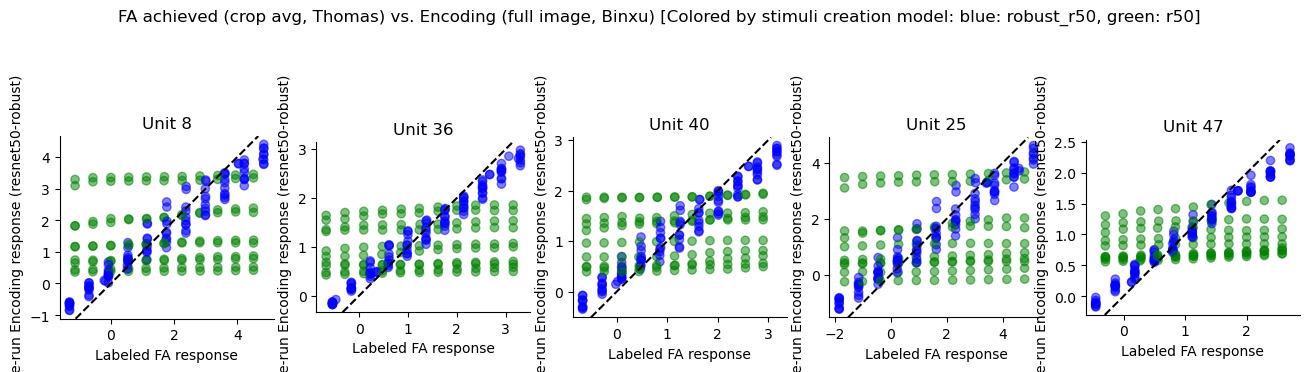

In [29]:
fa_unit_id = 47
fig, axs = plt.subplots(1, 5, figsize=(16, 4.5))
for fa_unit_id, ax in zip(fa_param_df.unit_id.unique(), axs):
    mask = fa_param_df.unit_id == fa_unit_id
    model_name = fa_param_df[mask].model_name
    model_name_colors = {
        "robust_r50": "b",
        "r50": "g",
    }
    ax.scatter(fa_param_df[mask].actual_score, population_pred[mask, fa_unit_id].cpu(), alpha=0.5, 
               color=[model_name_colors[m] for m in model_name]) # 
    ax.set_xlabel("Labeled FA response")
    ax.set_ylabel("Re-run Encoding response (resnet50-robust)")
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    ax.axis('image')
    ax.set_title(f"Unit {fa_unit_id}")
plt.suptitle("FA achieved (crop avg, Thomas) vs. Encoding (full image, Binxu) [Colored by stimuli creation model: blue: robust_r50, green: r50]")
plt.show()

In [19]:
population_pred.cpu()

tensor([[0.7493, 0.3927, 0.4787,  ..., 0.4672, 0.5379, 0.5869],
        [0.8138, 0.5296, 0.4793,  ..., 0.4848, 0.6790, 0.5274],
        [2.2754, 1.3148, 0.4845,  ..., 0.5099, 0.9048, 0.5360],
        ...,
        [1.4443, 0.8077, 0.4816,  ..., 0.5048, 0.6066, 0.5744],
        [1.1014, 0.3979, 0.4807,  ..., 0.4345, 0.4981, 0.5224],
        [0.7694, 0.3105, 0.4789,  ..., 0.4868, 0.6076, 0.5548]])

Viewed ResNet50

In [51]:
# load actual neuronal responses
dataroot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation"
datapath =  join(dataroot, "vvs-accentuate-day2_normalize_paul_241120.h5")
subject_id = "paul_20241120"
data_dict = load_neural_data(datapath, subject_id, stimroot)
resp_mat = data_dict['resp_mat']
stim_names = data_dict['stimulus_names']
stim_names_str = [stim_name.decode('utf8') for stim_name in stim_names]

In [49]:
resp_mat.shape

(1052, 64)

In [53]:
# find the index of png_files in stim_names_str
fa2_idx = [stim_names_str.index(f) for f in png_files]
fa2_resp_mat = resp_mat[fa2_idx, :]
fa2_resp_mat.shape


(738, 64)

### Comparing biological response, multi crop prediction and deterministic prediction

In [63]:
def compute_r2(pred, target):
    return 1 - ((pred - target) ** 2).mean() / target.var()

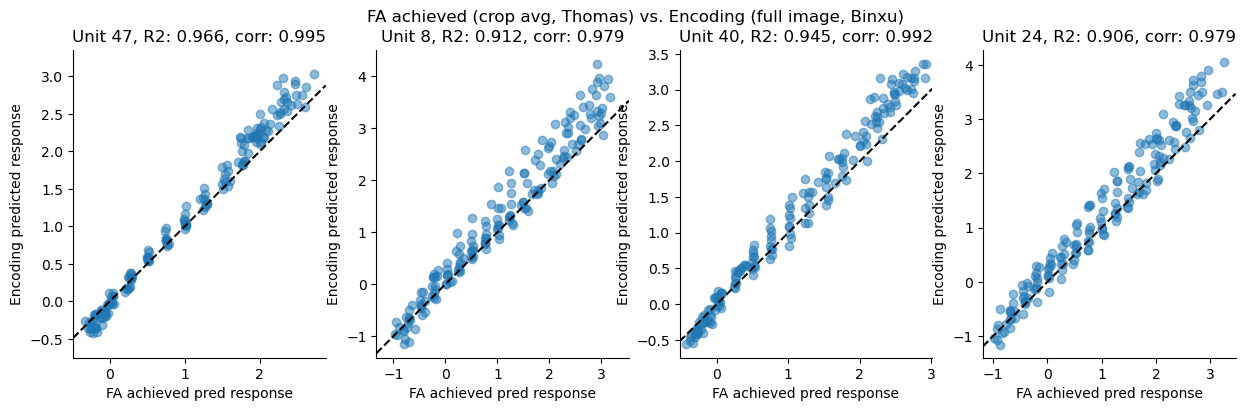

In [72]:
fa2_idx = [stim_names_str.index(f) for f in png_files]
fa2_resp_mat = resp_mat[fa2_idx, :]
fa_unit_id = 47
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for fa_unit_id, ax in zip(fa_param_df.unit_id.unique(), axs):
    mask = fa_param_df.unit_id == fa_unit_id
    neural_recording = fa2_resp_mat[mask, :][:, fa_unit_id]
    thomas_fa_pred = fa_param_df[mask].actual_score
    thomas_fa_target = fa_param_df[mask].target_score
    binxu_enc_pred = population_pred[mask, fa_unit_id].cpu().numpy()
    # ax.scatter(binxu_enc_pred, neural_recording , alpha=0.5)
    # ax.set_ylabel("Neural recording")
    # ax.set_xlabel("Encoding predicted response")
    # r2 = compute_r2(binxu_enc_pred, neural_recording) # compute r2
    # pearsonr = np.corrcoef(binxu_enc_pred, neural_recording)[0, 1]
    # ax.scatter(thomas_fa_pred, neural_recording , alpha=0.5)
    # ax.set_xlabel("FA achieved pred response")
    # ax.set_ylabel("Neural recording") 
    ax.scatter(thomas_fa_pred, binxu_enc_pred , alpha=0.5)
    ax.set_xlabel("FA achieved pred response")
    ax.set_ylabel("Encoding predicted response") 
    r2 = compute_r2(thomas_fa_pred, binxu_enc_pred) # compute r2
    pearsonr = np.corrcoef(thomas_fa_pred, binxu_enc_pred)[0, 1]
    ax.set_title(f"Unit {fa_unit_id}, R2: {r2:.3f}, corr: {pearsonr:.3f}")
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    ax.axis('equal')
plt.suptitle("FA achieved (crop avg, Thomas) vs. Encoding (full image, Binxu)")
plt.show()

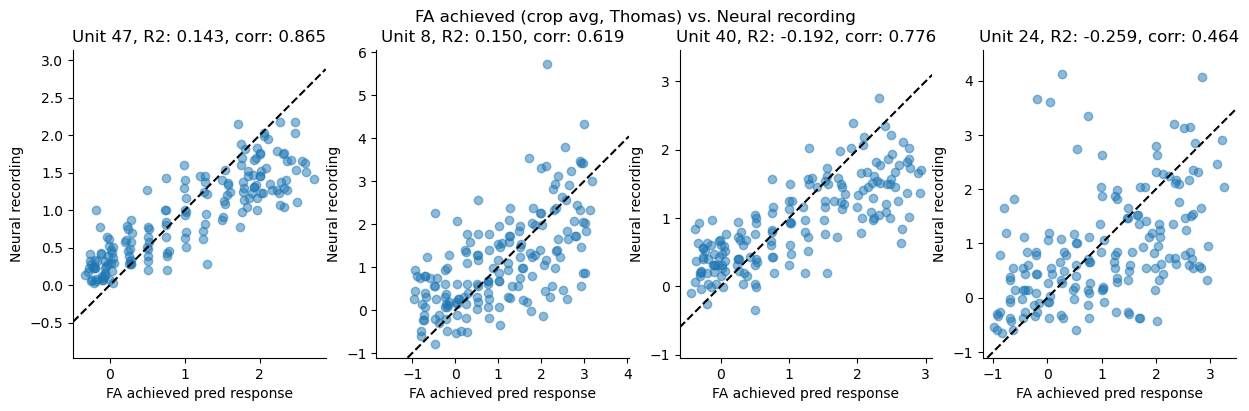

In [70]:
fa2_idx = [stim_names_str.index(f) for f in png_files]
fa2_resp_mat = resp_mat[fa2_idx, :]
fa_unit_id = 47
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for fa_unit_id, ax in zip(fa_param_df.unit_id.unique(), axs):
    mask = fa_param_df.unit_id == fa_unit_id
    neural_recording = fa2_resp_mat[mask, :][:, fa_unit_id]
    thomas_fa_pred = fa_param_df[mask].actual_score
    thomas_fa_target = fa_param_df[mask].target_score
    binxu_enc_pred = population_pred[mask, fa_unit_id].cpu()
    # ax.scatter(binxu_enc_pred, neural_recording , alpha=0.5)
    # ax.set_ylabel("Neural recording")
    # ax.set_xlabel("Encoding predicted response")
    # r2 = compute_r2(binxu_enc_pred, neural_recording) # compute r2
    # pearsonr = np.corrcoef(binxu_enc_pred, neural_recording)[0, 1]
    ax.scatter(thomas_fa_pred, neural_recording , alpha=0.5)
    ax.set_xlabel("FA achieved pred response")
    ax.set_ylabel("Neural recording") 
    r2 = compute_r2(thomas_fa_pred, neural_recording) # compute r2
    pearsonr = np.corrcoef(thomas_fa_pred, neural_recording)[0, 1]
    ax.set_title(f"Unit {fa_unit_id}, R2: {r2:.3f}, corr: {pearsonr:.3f}")
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    ax.axis('equal')
plt.suptitle("FA achieved (crop avg, Thomas) vs. Neural recording")
plt.show()

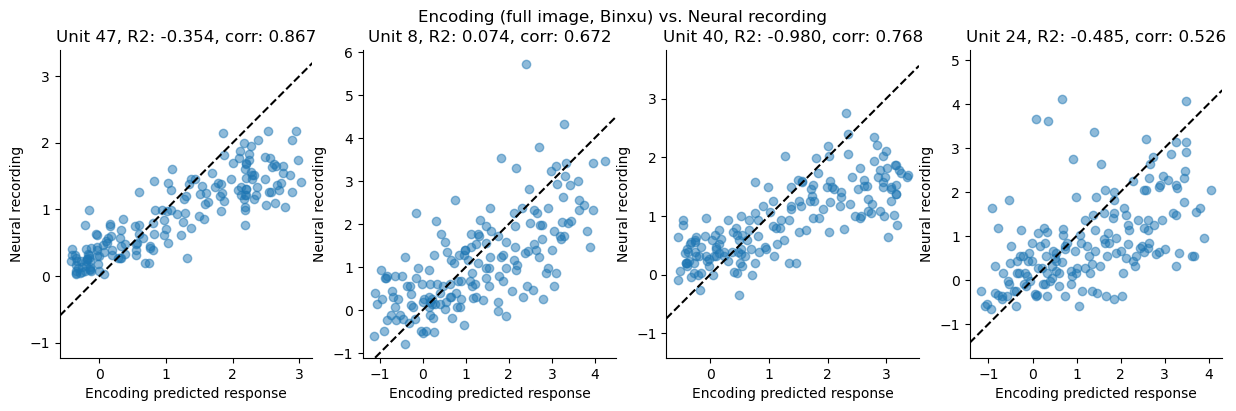

In [69]:
fa2_idx = [stim_names_str.index(f) for f in png_files]
fa2_resp_mat = resp_mat[fa2_idx, :]
fa_unit_id = 47
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
for fa_unit_id, ax in zip(fa_param_df.unit_id.unique(), axs):
    mask = fa_param_df.unit_id == fa_unit_id
    neural_recording = fa2_resp_mat[mask, :][:, fa_unit_id]
    thomas_fa_pred = fa_param_df[mask].actual_score
    thomas_fa_target = fa_param_df[mask].target_score
    binxu_enc_pred = population_pred[mask, fa_unit_id].cpu()
    ax.scatter(binxu_enc_pred, neural_recording , alpha=0.5)
    ax.set_ylabel("Neural recording")
    ax.set_xlabel("Encoding predicted response")
    r2 = compute_r2(binxu_enc_pred, neural_recording) # compute r2
    pearsonr = np.corrcoef(binxu_enc_pred, neural_recording)[0, 1]
    # ax.scatter(thomas_fa_pred, neural_recording , alpha=0.5)
    # ax.set_xlabel("FA achieved pred response")
    # ax.set_ylabel("Neural recording") 
    # r2 = compute_r2(thomas_fa_pred, neural_recording) # compute r2
    # pearsonr = np.corrcoef(thomas_fa_pred, neural_recording)[0, 1]
    ax.set_title(f"Unit {fa_unit_id}, R2: {r2:.3f}, corr: {pearsonr:.3f}")
    ax.axline((0, 0), slope=1, color='k', linestyle='--')
    ax.axis('equal')
plt.suptitle("Encoding (full image, Binxu) vs. Neural recording")
plt.show()

In [43]:
import h5py
import numpy as np


def load_from_hdf5(filename):
    """Loads an HDF5 file and returns it as a dictionary with the original structure."""
    def recursively_load_dict(group):
        result = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):  # If item is a group, load it as a dictionary
                result[key] = recursively_load_dict(item)
            else:  # Otherwise, load it as an array
                data = item[()]
                # Decode byte strings if necessary
                if isinstance(data, np.ndarray) and data.dtype.kind == 'S':  # Byte strings in NumPy arrays
                    data = np.array(data, dtype=str)
                elif isinstance(data, bytes):  # Single byte string
                    data = data.decode('utf-8')
                result[key] = data
        
        # Load any lists stored as attributes
        for key, item in group.attrs.items():
            result[key] = list(item) if isinstance(item, np.ndarray) else item
        
        return result
    
    with h5py.File(filename, 'r') as f:
        return recursively_load_dict(f)
    

def load_neural_data(data_path, subject_id, stimroot):
    """Load neural data and image file paths."""
    data = load_from_hdf5(data_path)
    # Meta data
    brain_area = data[subject_id]["neuron_metadata"]["brain_area"]
    ncsnr = data[subject_id]["neuron_metadata"]["ncsnr"]
    reliability = data[subject_id]["neuron_metadata"]["reliability"]
    # Display parameters
    stim_pos = data[subject_id]['trials']['stimulus_pos_deg']
    stim_size = data[subject_id]['trials']['stimulus_size_pix']
    # Response data
    resp_mat = data[subject_id]['repavg']['response_peak']  # Peak, avg response
    resp_temp_mat = data[subject_id]['repavg']['response_temporal']  # Temporal response
    stimulus_names = data[subject_id]['repavg']['stimulus_name']
    
    image_fps = [f"{stimroot}/{stimname.decode('utf8')}" for stimname in stimulus_names]
    return {
        'brain_area': brain_area,
        'ncsnr': ncsnr,
        'reliability': reliability,
        'stim_pos': stim_pos,
        'stim_size': stim_size,
        'resp_mat': resp_mat,
        'resp_temp_mat': resp_temp_mat,
        'image_fps': image_fps,
        "stimulus_names": stimulus_names,
    }

import os
def parse_image_fullpaths(stimulus_names, stimroots):
    """Parse image full paths from stimulus names and stimulus roots.
    
    Args:
        stimulus_names: List/array of stimulus names (potentially byte strings)
        stimroots: List of root directories to search for stimulus files
        
    Returns:
        image_fps: List of full paths to stimulus files, with None for missing files
    """
    image_fps = []
    for stimname in stimulus_names:
        file_non_exist = True
        # Convert byte string to regular string if needed
        stim_str = stimname.decode('utf8') if isinstance(stimname, bytes) else stimname
        for stimroot in stimroots:
            fullpath = os.path.join(stimroot, stim_str)
            if os.path.exists(fullpath):
                image_fps.append(fullpath)
                file_non_exist = False
                break
                
        if file_non_exist:
            print(f"File {stim_str} does not exist in any of the stimulus roots")
            image_fps.append(None)
    if not all(image_fps):
        print("Warning: Some stimulus files were not found")
    else:
        print("All stimulus files were found")
    return image_fps


def create_response_tensor(trials_stim_names, trials_resp_peak, rspavg_stim_names):
    """Create a 3D tensor (stimulus x neuron x trial) from trial responses.
    
    Args:
        trials_stim_names: Array of stimulus names for each trial
        trials_resp_peak: Array of peak responses for each trial (trial x neuron)
        rspavg_stim_names: Array of unique stimulus names
        
    Returns:
        resp_tensor: 3D tensor of responses (stimulus x neuron x max_trials)
        trial_counters: Number of trials per stimulus
    """
    # Create a dictionary mapping stimulus names to indices
    stim_to_idx = {name.decode('utf8'): i for i, name in enumerate(rspavg_stim_names)}
    # Initialize list to store trial counts for each stimulus
    trial_counts = np.zeros(len(rspavg_stim_names), dtype=int)
    # Count trials per stimulus
    for stim_name in trials_stim_names:
        trial_counts[stim_to_idx[stim_name.decode('utf8')]] += 1
    max_trials = trial_counts.max()
    # Initialize 3D tensor (stimulus x neuron x trial)
    resp_tensor = np.full((len(rspavg_stim_names), trials_resp_peak.shape[1], max_trials), np.nan)
    trial_counters = np.zeros(len(rspavg_stim_names), dtype=int)
    # Fill in the tensor with trial responses
    for trial_idx, (stim_name, trial_resp) in enumerate(zip(trials_stim_names, trials_resp_peak)):
        stim_idx = stim_to_idx[stim_name.decode('utf8')]
        resp_tensor[stim_idx, :, trial_counters[stim_idx]] = trial_resp
        trial_counters[stim_idx] += 1

    print(f"Response tensor shape (stimulus x neuron x trial): {resp_tensor.shape}")
    return resp_tensor, trial_counters


def load_neural_trial_resp_tensor(data_path, subject_id,):
    data = load_from_hdf5(data_path)
    trials_stim_names = data[subject_id]['trials']['stimulus_name']
    trials_resp_peak = data[subject_id]['trials']['response_peak']
    rspavg_stim_names = data[subject_id]['repavg']['stimulus_name']
    rspavg_resp_peak = data[subject_id]['repavg']['response_peak']
    print("Trials shape:", trials_stim_names.shape, trials_resp_peak.shape)
    print("Rspavg shape:", rspavg_stim_names.shape, rspavg_resp_peak.shape)
    resp_tensor, trial_counters = create_response_tensor(trials_stim_names, trials_resp_peak, rspavg_stim_names)
    print("Response tensor shape:", resp_tensor.shape)
    print("Trial counters shape:", trial_counters.shape)
    print("min and max trial counters:", trial_counters.min(), trial_counters.max())
    return rspavg_stim_names, rspavg_resp_peak, resp_tensor, trial_counters


In [46]:
stim_names = data_dict['stimulus_names']

In [48]:
stim_names_str = [stim_name.decode('utf8') for stim_name in stim_names]

In [39]:
resp_mat

array([[-0.22342022,  0.06997244, -0.5119617 , ...,  0.10252511,
         0.34760654,  0.8833993 ],
       [-0.893307  , -0.47561985,  0.32416272, ..., -0.1916668 ,
         0.83366275,  0.19268787],
       [-1.0641282 ,  0.00578512,  0.04545459, ...,  0.86742413,
        -0.16403157, -0.26778644],
       ...,
       [ 0.92041147,  0.67975205, -1.069378  , ..., -0.3681819 ,
         0.5266799 ,  1.1136365 ],
       [ 0.9555804 ,  1.0969697 ,  1.0673845 , ...,  1.6323231 ,
         1.1662276 ,  1.1903822 ],
       [ 2.7441778 ,  1.6425619 ,  0.32416272, ...,  1.3969696 ,
         0.9871542 ,  1.5741107 ]], dtype=float32)

In [14]:
import re
pattern = r'(\d+)_(\d+)_(pos|neg)_(-?\d+\.\d+)_(-?\d+\.\d+)\.png'
match = re.match(pattern, '47_4_pos_-1.0_-0.034209420531988145.png')
if match:
    unit_id, img_id, sign, target_score, actual_score = match.groups()
    print(f"Image ID: {img_id}")
    print(f"Unit ID: {unit_id}") 
    print(f"Sign: {sign}")
    print(f"Target score: {target_score}")
    print(f"Actual score: {actual_score}")

Image ID: 4
Unit ID: 47
Sign: pos
Target score: -1.0
Actual score: -0.034209420531988145


In [29]:
!echo {figdir}

/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/VVS_Accentuation/model_outputs/paul_20241119


In [28]:
!ls {figdir}

paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.pdf
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.png
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis.pdf
paul_20241119_resnet50_clip_layer_sweep_GridCV_synopisis.png
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_fitmodels_RidgeCV.pth
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_sweep_RidgeCV.csv
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_sweep_RidgeCV_formatted.csv
paul_20241119_resnet50_clip_sweep_regressors_highreliab_layers_Xtfmer_RidgeCV.pkl
paul_20241119_resnet50_clip_sweep_regressors_layers_pred_meta.pkl
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.pdf
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis_D2perunit_ncsnr_scatter.png
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis.pdf
paul_20241119_resnet50_dino_layer_sweep_GridCV_synopisis.png
paul_202411

In [25]:
regressor

PCA(n_components=1000)

In [ ]:
device = "cuda"
layer_name = ".layer4.Bottleneck1"  #key[0]
model, transforms_pipeline = load_model_transform(modelname, device=device)
fetcher = featureFetcher(model, input_size=(3, 224, 224), print_module=False)
fetcher.record(layer_name,  ingraph=True, store_device=device)
# # Define the readout layer and load weights
state_dict = th.load(readout_path)
readout = nn.Linear(state_dict['weight'].shape[1], state_dict['weight'].shape[0], bias=True).cuda()
readout.load_state_dict(state_dict)
pca = pkl.load(open(Xtransform_path, "rb"))
Xtransform = PCA_torch(pca, device=device)
# Define the prediction pipeline
def objective(images):
    # Forward pass through the feature extractor
    model(images)
    feat_tsr = fetcher[layer_name]  # Access the layer4 feature
    feat_vec = Xtransform(feat_tsr)
    return readout(feat_vec).mean(dim=1).mean()

check_gradient(objective)
# Optimization part 1: MACO
image1, alpha1 = maco(objective, **maco_hyperparams, device='cuda')
plot_maco(image1, alpha1)
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_population_mean")
plt.show()

img_col = []
for unit_id in range(len(D2)):
    print(f"Optimizing unit {unit_id}")
    print(f"D^2: {D2[unit_id]}")

    def unit_objective(images):
        # Forward pass through the feature extractor
        model(images)
        feat_tsr = fetcher[layer_name]  # Access the layer4 feature
        feat_vec = Xtransform(feat_tsr)
        return readout(feat_vec)[:, unit_id].mean()
    
    image_unit, alpha_unit = maco(unit_objective, **maco_hyperparams, device='cuda')
    img_col.append((image_unit, alpha_unit))
    plot_maco(image_unit, alpha_unit)

visualize_results(img_col, D2, )
plt.suptitle(f"{subject_id} {modelname} {layer_name} {RD_method} MACO unit compilation")
saveallforms(figdir, f"{subject_id}_{modelname}_{layer_name}_{RD_method}_MACO_unit_cmp")